(sec:structopt-methods)=
# Optimization methods

The first class of special points on the PES that we will discuss are local energy minima. These correspond to equilibrium molecular structures and are characterized by a vanishing first order energy derivative combined with a Hessian matrix which has only positive eigenvalues. The procedure to determine a local minimum (i.e. finding the coordinates that minimize the energy) is called a structure optimization.  

```{figure} ../../img/pes/PES.png
```
In practical terms, the ingredients to perform a geometry optimization include: (1) the initial molecular coordinates, (2) a choice of coordinate system, (3) the energy at a specific geometry $E(\mathbf{x})$, (4) the gradient $\mathbf{g}(\mathbf{x})=\nabla E(\mathbf{x})$, (5) the Hessian, and (6) a procedure to update the coordinates and Hessian and move on the potential energy surface towards lower energy. 

Having addressed [the issue of coordinate system](coord), the remaining question is what procedure to use to move along the potential energy surface and arrive at a local energy minimum. There are several iterative methods to do this, some of which need only information on the energy gradient (e.g. gradient-descent, conjugate gradient), while others take into account also the Hessian (Newton--Raphson, quasi-Newton). For a detailed review of minimization techniques, see {cite}`Snyman2005`.

## Gradient descent

The simplest optimization procedure is to repeatedly take a step in the direction opposite to the local gradient
%
\begin{equation}
\mathbf{x}_{i+1} = \mathbf{x}_i - k_i\mathbf{g}(\mathbf{x}_i) \nonumber 
\end{equation}
where by $\mathbf{x}_{i+1}$ we denote the new coordinates (in a generic coordinate system -- either Cartesian or internal coordinates), $\mathbf{x}_i$ are the coordinates at the previous step $i$, $\nabla E$ is the energy gradient and $k_i$ is the step size. The step size can either be kept constant, or adjusted at each iteration, e.g. by the line search procedure.

The gradient-descent method is simple to implement and is guaranteed to converge, but has the disadvantage that it requires many steps and becomes slow when close to the minimum where the gradient is small. It always converges to a local minimum, given enough steps.


### Implementation
Let's implement the gradient descent method. We will need to set up a molecule, an SCF driver and a gradient driver.

In [1]:
# Import section
import veloxchem as vlx
import py3Dmol as p3d
from veloxchem.veloxchemlib import bohr_in_angstroms
import numpy as np
from matplotlib import pyplot as plt

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.


In [2]:
# Define the molecule
molecule_xyz = """6
ethylene molecule from https://molview.org/
C   -0.6672    0.0000    0.0000
C    0.6672    0.0000    0.0000
H   -1.2213   -0.9290    0.0708
H   -1.2212    0.9290   -0.0708
H    1.2213    0.9290   -0.0708
H    1.2213   -0.9290    0.0708
"""
molecule = vlx.Molecule.from_xyz_string(molecule_xyz)

In [3]:
view = p3d.view(linked=True, viewergrid=(1,1),width=400,height=300)
view.addModel(molecule_xyz, 'xyz', viewer=(0,0))
view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({'stick': {}, 'sphere': {'scale':0.25}})
view.rotate(-90, "x")
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
# XTB Energy driver
xtb_drv = vlx.XtbDriver()

# Gradient driver
xtb_grad_driver = vlx.XtbGradientDriver()
xtb_grad_driver.ostream.state = False

Now, write your own routine to run one gradient descent iteration:
```python
def gradient_descent_iteration(coordinates, gradient, step):
    ...
    return new_coordinates
```

In [5]:
def gradient_descent_iteration(coordinates, gradient, step):
    new_coordinates = coordinates - step * gradient
    return new_coordinates

And the routine that runs the optimization:
```python
def gradient_descent(molecule, energy_driver, gradient_driver,
                     step=0.1, threshold=1e-3, max_iter=10):

    # create ostream for xtb driver
    ostream = vlx.OutputStream()
    
    iteration = 0
    grad_norm = 100
    
    # save atom labels (symbols)
    labels = molecule.get_labels()
    
    # initial atomic coordinates
    old_coords = molecule.get_coordinates()
    
    energy_driver.compute(molecule, ostream)
    old_energy = energy_driver.get_energy()
    
    gradient_driver.compute(molecule, energy_driver)
    old_gradient = gradient_driver.get_gradient()
    
    print("Starting gradient descent:\n")
    text = "Iteration     Energy (H)      "
    text += "Max. displacement (bohr)    Gradient norm (H/bohr)"
    print(text)
    energies = [old_energy]
    iterations = [0]
    
    while (grad_norm >= threshold) and (iteration <= max_iter):
        ...
        ...
        ...
        
    if iteration <= max_iter:
        text = "\n   *** Gradient Descent converged in "
        text += "%d iteration(s). *** " % iteration
        print(text)
    else:
        print("\n   !!! Gradient Descent did not converge  !!! ")
        new_molecule = None
    return new_molecule, iterations, energies 
```

In [6]:
def gradient_descent(molecule, xtb_driver, xtb_gradient_driver,
                     step=0.1, threshold=1e-3, max_iter=10):
    
    iteration = 0
    grad_norm = 100
    
    # save atom labels (symbols)
    labels = molecule.get_labels()
    
    # initial atomic coordinates
    old_coords = molecule.get_coordinates()
    
    xtb_driver.mute()
    xtb_driver.compute(molecule)
    old_energy = xtb_driver.get_energy()
    
    xtb_gradient_driver.compute(molecule, xtb_driver)
    old_gradient = xtb_gradient_driver.get_gradient()

    print("Starting gradient descent:\n")
    text = "Iteration     Energy (H)      "
    text += "Max. displacement (bohr)    Gradient norm (H/bohr)"
    print(text)
    energies = [old_energy]
    iterations = [0]
    
    while (grad_norm >= threshold) and (iteration <= max_iter):
        coords = gradient_descent_iteration(old_coords, old_gradient, step)
        
        # calculate the energy and gradient corresponding to the new coordinates
        new_molecule = vlx.molecule.Molecule(labels, coords, units='au')
        
        xtb_driver.mute()
        xtb_driver.compute(new_molecule)
        energy = xtb_driver.get_energy()
        energies.append(energy)
        
        xtb_gradient_driver.compute(new_molecule, xtb_driver)
        gradient = xtb_gradient_driver.get_gradient()
        grad_norm = np.linalg.norm(gradient)
        
        displacement = old_coords - coords
        max_disp = np.amax(abs(displacement))
        
        # calculate energy difference
        delta_e = abs(energy - old_energy)
        text = "   %3d.  %15.7f      " % (iteration, energy, )
        text += "%15.7f          %15.7f" % (max_disp, grad_norm)
        print(text)
        
        # save 
        old_energy = energy
        old_gradient = gradient
        old_coords = coords
        iteration += 1
        iterations.append(iteration)
        
    if iteration <= max_iter:
        text = "\n   *** Gradient Descent converged in "
        text += "%d iteration(s). *** " % iteration
        print(text)
    else:
        print("\n   !!! Gradient Descent did not converge  !!! ")
        new_molecule = None
    return new_molecule, iterations, energies 

In [15]:
opt_mol, gd_iterations, gd_energies = gradient_descent(molecule,
                                                       xtb_drv, xtb_grad_driver,
                                                       step = 0.05,
                                                       threshold=1e-3,
                                                       max_iter=450)

Starting gradient descent:

Iteration     Energy (H)      Max. displacement (bohr)    Gradient norm (H/bohr)
     0.       -6.2705883            0.0009519                0.0278012
     1.       -6.2706259            0.0008925                0.0263887
     2.       -6.2706599            0.0008367                0.0250762
     3.       -6.2706905            0.0007843                0.0238580
     4.       -6.2707183            0.0007352                0.0227284
     5.       -6.2707435            0.0006892                0.0216819
     6.       -6.2707665            0.0006461                0.0207131
     7.       -6.2707875            0.0006057                0.0198170
     8.       -6.2708067            0.0005679                0.0189885
     9.       -6.2708244            0.0005326                0.0182228
    10.       -6.2708407            0.0004995                0.0175154
    11.       -6.2708557            0.0004685                0.0168617
    12.       -6.2708697            0.0

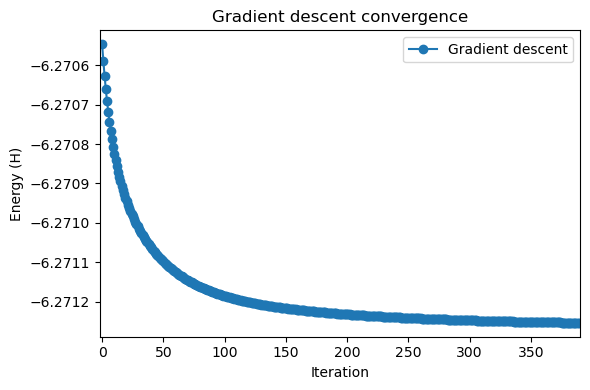

In [18]:
plt.figure(figsize=(6,4))

plt.plot(gd_iterations, gd_energies,'o-', label='Gradient descent')

plt.axis(xmin=-2, xmax=390)

plt.xlabel('Iteration')
plt.ylabel('Energy (H)')
plt.title("Gradient descent convergence")
plt.legend()
plt.tight_layout(); plt.show()